# Masar CrowdSim — QA Notebook (GitHub-linked)

This notebook **pulls your weekly CSV directly from GitHub** (e.g., `cf_week_f.csv`) and generates QA checks & charts.

### How to use
1. Fill `OWNER`, `REPO`, `BRANCH`, and `FILE_PATH` (defaults target `masar-sim/data/generated/cf_week_f.csv`).  
   **OR** paste a full `RAW_URL` if you prefer.
2. Run the **Fetch from GitHub** cell to download the latest CSV.
3. Run the QA & charts cells.

> Works in Colab/Jupyter with internet access. Uses only Matplotlib (no seaborn).


In [ ]:
#set  GitHub repo details
OWNER = 'Jana-Alrzoog'
REPO  = '2025_GP_28'
BRANCH = 'main'
FILE_PATH = 'masar-sim/data/generated/cf_week_f.csv'

RAW_URL = None

# Download destination (local)
LOCAL_CSV = '/content/cf_week_f.csv'
print('Ready. If your repo is public, constructed raw URL will work. If private, use an auth method (see below).')

Ready. If your repo is public, constructed raw URL will work. If private, use an auth method (see below).


In [ ]:
#Fetch from GitHub
import os, sys, io
import requests

def guess_raw_url(owner, repo, branch, file_path):
    return f'https://raw.githubusercontent.com/{owner}/{repo}/{branch}/{file_path.lstrip("/")}'

url = RAW_URL or guess_raw_url(OWNER, REPO, BRANCH, FILE_PATH)
print('Raw URL →', url)

resp = requests.get(url, timeout=60)
if resp.status_code != 200:
    raise RuntimeError(f'Failed to fetch CSV (status {resp.status_code}). Check OWNER/REPO/BRANCH/FILE_PATH or RAW_URL.')

with open(LOCAL_CSV, 'wb') as f:
    f.write(resp.content)

print('Saved to', LOCAL_CSV, '| Bytes:', len(resp.content))

Raw URL → https://raw.githubusercontent.com/Jana-Alrzoog/2025_GP_28/main/masar-sim/data/generated/cf_week_f.csv
Saved to /content/cf_week_f.csv | Bytes: 3833457


In [ ]:
#Load CSV & Schema Checks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = LOCAL_CSV  # keep consistent
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(CSV_PATH)

df = pd.read_csv(CSV_PATH, encoding='utf-8-sig', low_memory=False)

REQUIRED = [
    'date','timestamp','hour','minute_of_day','day_of_week','is_weekend',
    'station_id','base_demand','modifier','demand_final',
    'station_total','crowd_level','special_event_type','event_flag','holiday_flag',
    'headway_seconds'
]
missing = [c for c in REQUIRED if c not in df.columns]
if missing:
    raise RuntimeError(f'Missing columns: {missing}')

# Coerce types
df['date'] = df['date'].astype(str)
df['minute_of_day'] = pd.to_numeric(df['minute_of_day'], errors='coerce').fillna(0).astype(int)
for c in ['hour','day_of_week','is_weekend','event_flag','holiday_flag','headway_seconds']:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)
for c in ['base_demand','modifier','demand_final','station_total']:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0.0)

print('Rows:', len(df), '| Stations:', df['station_id'].nunique(), '| Dates:', df['date'].nunique())
df.head(3)

Rows: 38886 | Stations: 6 | Dates: 7


,date,timestamp,hour,minute_of_day,day_of_week,is_weekend,station_id,base_demand,modifier,demand_final,station_total,crowd_level,special_event_type,event_flag,holiday_flag,headway_seconds
0,9/21/2025,9/21/2025 6:00,6,360,6,0,S1,0.078566,1.0,0.078566,108,Low,NaN,0,0,660
1,9/21/2025,9/21/2025 6:01,6,361,6,0,S1,0.080302,1.0,0.080302,110,Low,NaN,0,0,660
2,9/21/2025,9/21/2025 6:02,6,362,6,0,S1,0.082128,1.0,0.082128,113,Low,NaN,0,0,660


,0
date,
9/21/2025,6480
9/22/2025,6480
9/23/2025,6480
9/24/2025,6
9/25/2025,6480
9/26/2025,6480
9/27/2025,6480


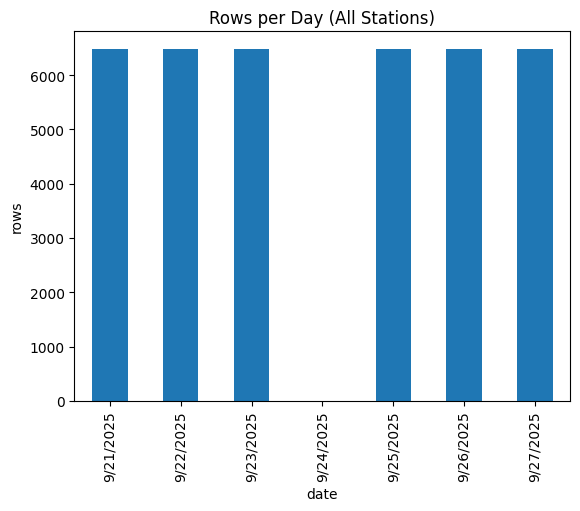

In [ ]:
#Rows per Day
cnt = df.groupby('date').size()
display(cnt)

plt.figure()
cnt.sort_index().plot(kind='bar')
plt.title('Rows per Day (All Stations)')
plt.xlabel('date')
plt.ylabel('rows')
plt.show()

,station_total
is_weekend,
Weekday,576.834529
Weekend,364.197377


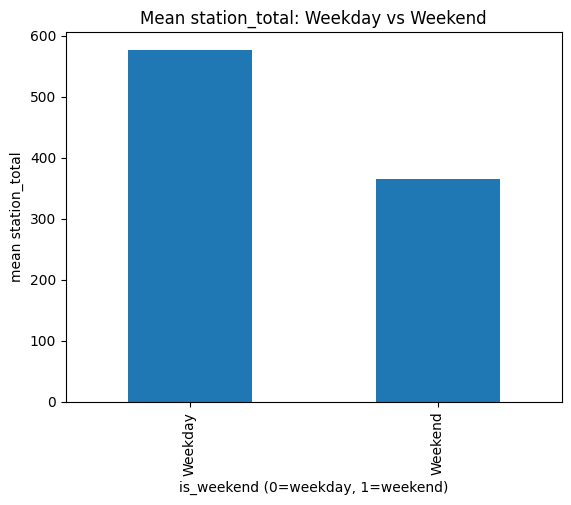

In [ ]:
#Weekend vs Weekday
wkd = df.groupby('is_weekend')['station_total'].mean().rename({0:'Weekday',1:'Weekend'})
display(wkd)

plt.figure()
wkd.plot(kind='bar')
plt.title('Mean station_total: Weekday vs Weekend')
plt.xlabel('is_weekend (0=weekday, 1=weekend)')
plt.ylabel('mean station_total')
plt.show()

,mean,median,max,count
day_type,,,,
Event (9/23/2025),1094.029012,291.0,6050,6480
No Event (9/21/2025),404.591512,128.0,2696,6480


<Figure size 700x500 with 0 Axes>

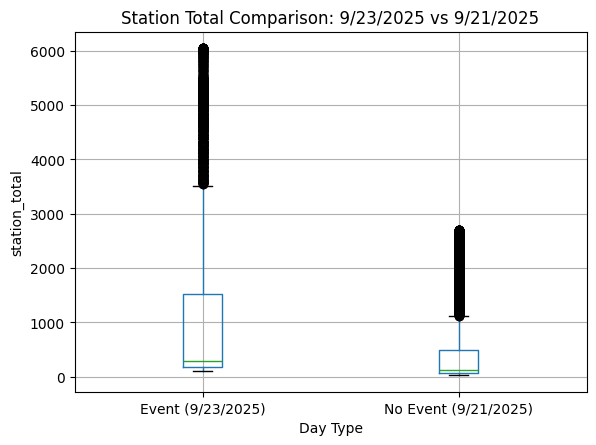

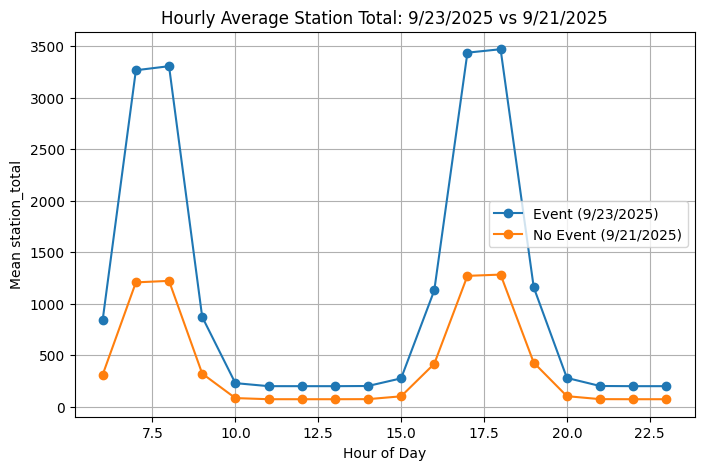

In [ ]:
#Compare specific days
day_event = "9/23/2025"   # day with event
day_normal = "9/21/2025"  # day without event


df_event = df[df["date"] == day_event].copy()
df_normal = df[df["date"] == day_normal].copy()


if df_event.empty or df_normal.empty:
    print("⚠️ تأكدي من التواريخ: ما فيه بيانات لأحد اليومين.")
    print("الأيام الموجودة فعليًا:", df["date"].unique()[:10])
else:

    df_event["day_type"] = f"Event ({day_event})"
    df_normal["day_type"] = f"No Event ({day_normal})"
    df_cmp = pd.concat([df_event, df_normal], axis=0, ignore_index=True)

    stats = df_cmp.groupby("day_type")["station_total"].agg(["mean", "median", "max", "count"])
    display(stats)


    plt.figure(figsize=(7,5))
    df_cmp.boxplot(column="station_total", by="day_type", grid=True)
    plt.title(f"Station Total Comparison: {day_event} vs {day_normal}")
    plt.suptitle("")
    plt.xlabel("Day Type")
    plt.ylabel("station_total")
    plt.show()

    # print the graph
    plt.figure(figsize=(8,5))
    for label, sub in df_cmp.groupby("day_type"):
        hourly = sub.groupby("hour")["station_total"].mean()
        plt.plot(hourly.index, hourly.values, marker="o", label=label)
    plt.title(f"Hourly Average Station Total: {day_event} vs {day_normal}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Mean station_total")
    plt.legend()
    plt.grid(True)
    plt.show()


Correlation (demand_final vs station_total) = 0.8275


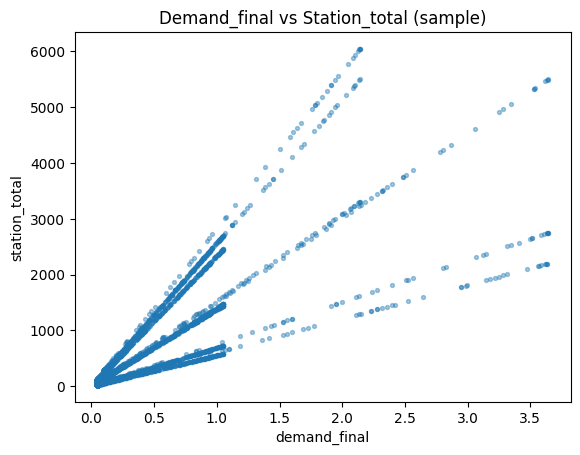

In [ ]:
#Demand vs Station Total correlation
sample = df.sample(min(5000, len(df)), random_state=42)
corr = sample[['demand_final','station_total']].corr().iloc[0,1]
print('Correlation (demand_final vs station_total) =', round(corr, 4))

plt.figure()
plt.scatter(sample['demand_final'], sample['station_total'], s=8, alpha=0.4)
plt.title('Demand_final vs Station_total (sample)')
plt.xlabel('demand_final')
plt.ylabel('station_total')
plt.show()

,headway_seconds
count,38886.000000
mean,633.337448
std,75.420601
min,420.000000
25%,660.000000
50%,660.000000
75%,660.000000
max,660.000000


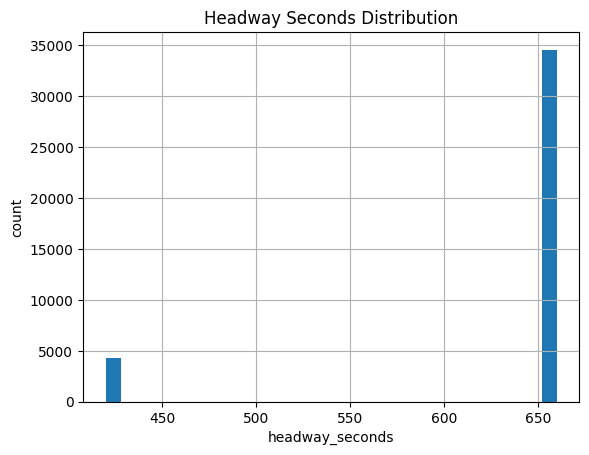

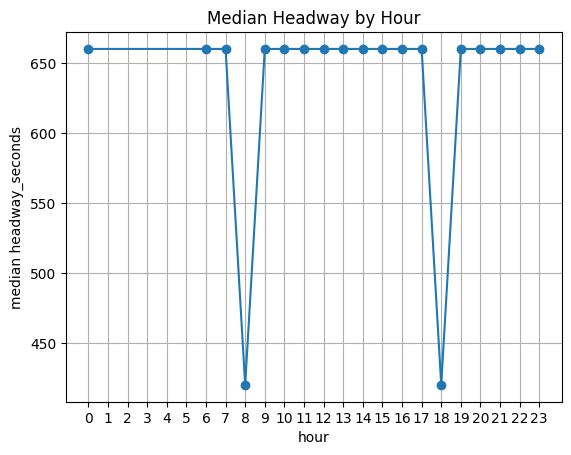

In [ ]:
#Headway sanity
hw = df['headway_seconds'].describe()
display(hw)

plt.figure()
df['headway_seconds'].hist(bins=30)
plt.title('Headway Seconds Distribution')
plt.xlabel('headway_seconds')
plt.ylabel('count')
plt.show()

hhw = df.groupby('hour')['headway_seconds'].median()
plt.figure()
hhw.plot(kind='line', marker='o')
plt.title('Median Headway by Hour')
plt.xlabel('hour')
plt.ylabel('median headway_seconds')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

Day: 9/21/2025 | Station: S1 | rows: 1080


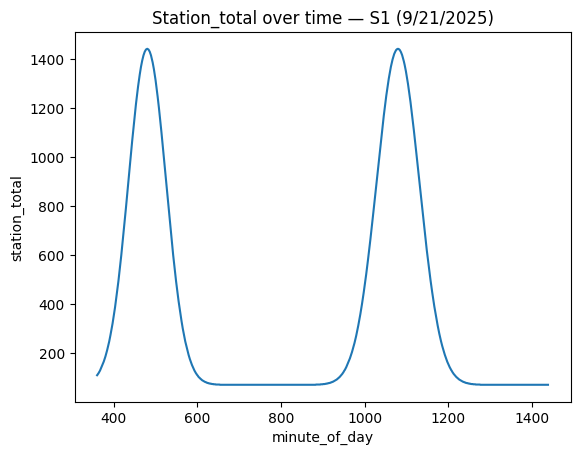

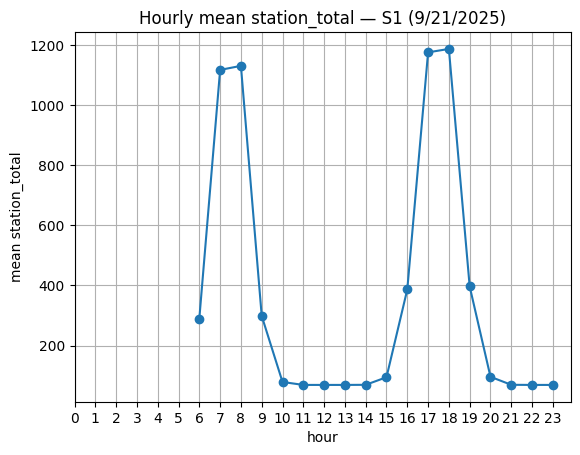

In [ ]:
#Focus Day/Station (Params)
DAY_OF_INTEREST = df['date'].value_counts().idxmax()
STATION_OF_INTEREST = df['station_id'].value_counts().idxmax()

day_df = df[df['date'] == DAY_OF_INTEREST].copy().sort_values('minute_of_day')
sdf = day_df[day_df['station_id']==STATION_OF_INTEREST].copy()

print('Day:', DAY_OF_INTEREST, '| Station:', STATION_OF_INTEREST, '| rows:', len(sdf))

plt.figure()
plt.plot(sdf['minute_of_day'], sdf['station_total'])
plt.title(f'Station_total over time — {STATION_OF_INTEREST} ({DAY_OF_INTEREST})')
plt.xlabel('minute_of_day')
plt.ylabel('station_total')
plt.show()

# Hourly profile
prof = sdf.groupby('hour')['station_total'].mean()
plt.figure()
prof.plot(kind='line', marker='o')
plt.title(f'Hourly mean station_total — {STATION_OF_INTEREST} ({DAY_OF_INTEREST})')
plt.xlabel('hour'); plt.ylabel('mean station_total'); plt.xticks(range(0,24)); plt.grid(True); plt.show()

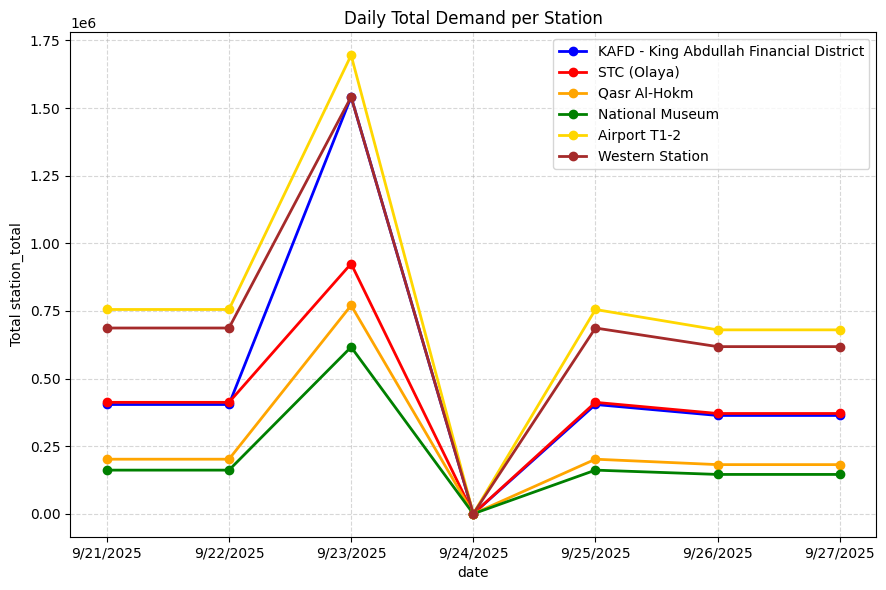

In [ ]:
# Daily Total Demand per Station
import matplotlib.pyplot as plt

station_info = {
    "S1": {"name": "KAFD - King Abdullah Financial District", "color": "blue"},
    "S2": {"name": "STC (Olaya)", "color": "red"},
    "S3": {"name": "Qasr Al-Hokm", "color": "orange"},
    "S4": {"name": "National Museum", "color": "green"},
    "S5": {"name": "Airport T1-2", "color": "gold"},
    "S6": {"name": "Western Station", "color": "brown"}
}

daily = df.groupby(["date", "station_id"])["station_total"].sum().reset_index()

plt.figure(figsize=(9,6))
for sid, group in daily.groupby("station_id"):
    info = station_info.get(sid, {"name": sid, "color": "gray"})
    plt.plot(group["date"], group["station_total"],
             label=info["name"],
             color=info["color"],
             marker="o", linewidth=2)

plt.title("Daily Total Demand per Station")
plt.xlabel("date")
plt.ylabel("Total station_total")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


,mean,median,max,count
day_type,,,,
Event (9/23/2025),1094.029012,291.0,6050,6480
No Event (9/21/2025),404.591512,128.0,2696,6480


<Figure size 700x500 with 0 Axes>

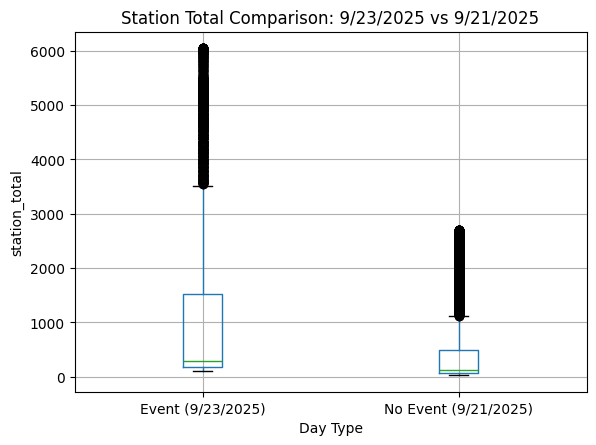

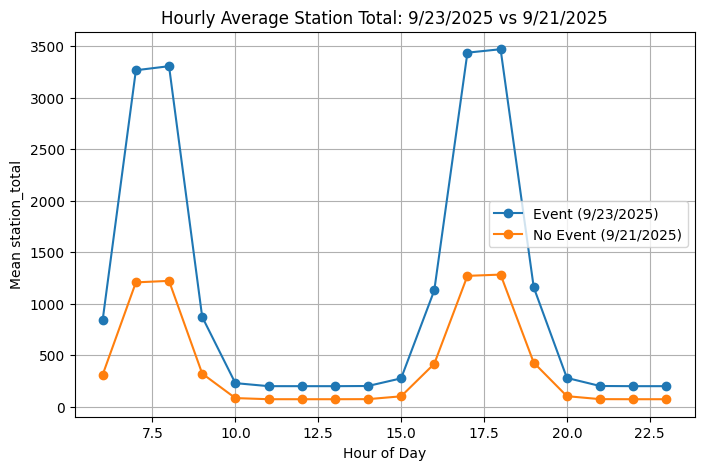

In [ ]:
#Compare specific days
day_event = "9/23/2025"
day_normal = "9/21/2025"


df_event = df[df["date"] == day_event].copy()
df_normal = df[df["date"] == day_normal].copy()


if df_event.empty or df_normal.empty:
    print("⚠️ تأكدي من التواريخ: ما فيه بيانات لأحد اليومين.")
    print("الأيام الموجودة فعليًا:", df["date"].unique()[:10])
else:

    df_event["day_type"] = f"Event ({day_event})"
    df_normal["day_type"] = f"No Event ({day_normal})"
    df_cmp = pd.concat([df_event, df_normal], axis=0, ignore_index=True)


    stats = df_cmp.groupby("day_type")["station_total"].agg(["mean", "median", "max", "count"])
    display(stats)

    # Boxplot of the tow days
    plt.figure(figsize=(7,5))
    df_cmp.boxplot(column="station_total", by="day_type", grid=True)
    plt.title(f"Station Total Comparison: {day_event} vs {day_normal}")
    plt.suptitle("")
    plt.xlabel("Day Type")
    plt.ylabel("station_total")
    plt.show()


    plt.figure(figsize=(8,5))
    for label, sub in df_cmp.groupby("day_type"):
        hourly = sub.groupby("hour")["station_total"].mean()
        plt.plot(hourly.index, hourly.values, marker="o", label=label)
    plt.title(f"Hourly Average Station Total: {day_event} vs {day_normal}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Mean station_total")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
#Save QA summary JSON next to the CSV path
import os, json

summary = {
    'rows_total': int(len(df)),
    'stations': int(df['station_id'].nunique()),
    'dates': int(df['date'].nunique()),
    'extreme_share_pct': float((df['crowd_level']=='Extreme').mean()*100.0),
    'high_plus_extreme_share_pct': float((df['crowd_level'].isin(['High','Extreme'])).mean()*100.0),
    'median_headway_sec': float(df['headway_seconds'].median()),
    'mean_station_total': float(df['station_total'].mean()),
}

qa_out = os.path.splitext(CSV_PATH)[0] + '_QA_summary.json'
with open(qa_out, 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print('Saved QA summary →', qa_out)
summary

Saved QA summary → /content/cf_week_f_QA_summary.json


{'rows_total': 38886,
 'stations': 6,
 'dates': 7,
 'extreme_share_pct': 2.1910199043357506,
 'high_plus_extreme_share_pct': 3.3945378799567965,
 'median_headway_sec': 660.0,
 'mean_station_total': 505.96641464794527}